In [1]:
!pip install -U -q segmentation-models

!pip install -q tensorflow
!pip install -q keras
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [2]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow as tf
import keras

im_56.tifpatch_05.tif
im_56.tifpatch_05.tif


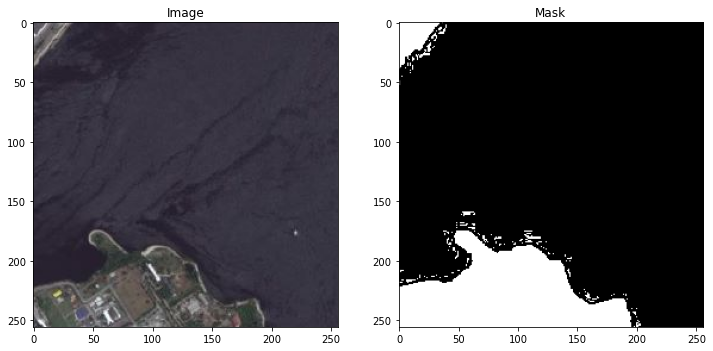

In [3]:

# tf.compat.v1.disable_eager_execution() #in case the model gets very slow, may be due to a bug in TF2.0. Uncomment this. 
#https://github.com/tensorflow/tensorflow/issues/33024

#Also check this in case you notice training to be getting increasingly slow each epoch.
# https://stackoverflow.com/questions/53683164/keras-occupies-an-indefinitely-increasing-amount-of-memory-for-each-epoch

################################################################
#Get an understanding by looking at a few random images and masks 

train_img_dir = "data_for_keras_aug/train_images/train/"
train_mask_dir = "data_for_keras_aug/train_masks/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)
num_images = len(os.listdir(train_img_dir))

#print(img_list)
img_num = random.randint(0, num_images-1)
#print(img_num)
print(img_list[img_num])
print(msk_list[img_num])
img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [4]:
seed=24
batch_size= 16
n_classes=2

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical

#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

#Define a function to perform additional preprocessing after datagen.
#For example, scale images, convert masks to categorical, etc. 
def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    #Convert mask to one-hot
    mask = to_categorical(mask, num_class)
    return (img,mask)

#Define the generator.
#We are not doing any rotation or zoom to make sure mask values are not interpolated.
#It is important to keep pixel values in mask as 0, 1, 2, 3, .....
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)



Found 4887 images belonging to 1 classes.
Found 4887 images belonging to 1 classes.


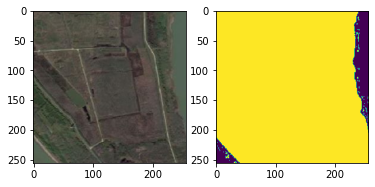

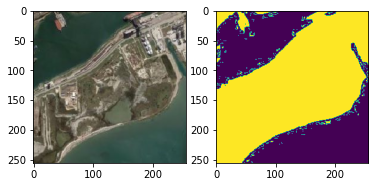

Found 1629 images belonging to 1 classes.
Found 1629 images belonging to 1 classes.


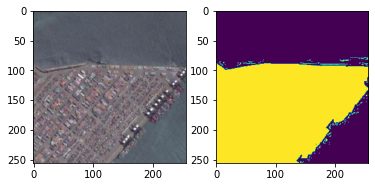

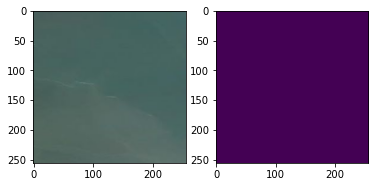

In [5]:

################################################################

# Define Generator for images and masks so we can read them directly from the drive. 


train_img_path = "data_for_keras_aug/train_images/"
train_mask_path = "data_for_keras_aug/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=2)

val_img_path = "data_for_keras_aug/val_images/"
val_mask_path = "data_for_keras_aug/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=2)

#Make sure the generator is working and that images and masks are indeed lined up. 
#Verify generator.... In python 3 next() is renamed as __next__()
x, y = train_img_gen.__next__()

for i in range(0,2):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

x_val, y_val = val_img_gen.__next__()

for i in range(0,2):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

In [6]:


###########################################################################
#Define the model metrcis and load model. 

num_train_imgs = len(os.listdir('data_for_keras_aug/train_images/train/'))
num_val_images = len(os.listdir('data_for_keras_aug/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size


IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes=2

#############################################################################
#Use transfer learning using pretrained encoder in the U-Net
#(make sure you uncomment the preprocess_input part in the
# preprocess_data function above)
################################################################
#Define the model
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='softmax')
model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])
#1model.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
print(model.summary())
print(model.input_shape)
#Fit the model
#history = model.fit(train_img_gen, validation_data=validation_datagen, steps_per_epoch=len(X_train) // 16, validation_steps=len(X_train) // 16, epochs=100)
#Train the model. 


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']   

 D)                                                                                               
                                                                                                  
 stage1_unit3_conv1 (Conv2D)    (None, 64, 64, 64)   36864       ['zero_padding2d_6[0][0]']       
                                                                                                  
 stage1_unit3_bn2 (BatchNormali  (None, 64, 64, 64)  256         ['stage1_unit3_conv1[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage1_unit3_relu2 (Activation  (None, 64, 64, 64)  0           ['stage1_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padd

                                                                                                  
 stage2_unit3_relu2 (Activation  (None, 32, 32, 128)  0          ['stage2_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_13 (ZeroPadding  (None, 34, 34, 128)  0          ['stage2_unit3_relu2[0][0]']     
 2D)                                                                                              
                                                                                                  
 stage2_unit3_conv2 (Conv2D)    (None, 32, 32, 128)  147456      ['zero_padding2d_13[0][0]']      
                                                                                                  
 add_5 (Add)                    (None, 32, 32, 128)  0           ['stage2_unit3_conv2[0][0]',     
          

                                                                                                  
 stage3_unit2_conv2 (Conv2D)    (None, 16, 16, 256)  589824      ['zero_padding2d_19[0][0]']      
                                                                                                  
 add_8 (Add)                    (None, 16, 16, 256)  0           ['stage3_unit2_conv2[0][0]',     
                                                                  'add_7[0][0]']                  
                                                                                                  
 stage3_unit3_bn1 (BatchNormali  (None, 16, 16, 256)  1024       ['add_8[0][0]']                  
 zation)                                                                                          
                                                                                                  
 stage3_unit3_relu1 (Activation  (None, 16, 16, 256)  0          ['stage3_unit3_bn1[0][0]']       
 )        

                                                                                                  
 stage3_unit6_relu1 (Activation  (None, 16, 16, 256)  0          ['stage3_unit6_bn1[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_26 (ZeroPadding  (None, 18, 18, 256)  0          ['stage3_unit6_relu1[0][0]']     
 2D)                                                                                              
                                                                                                  
 stage3_unit6_conv1 (Conv2D)    (None, 16, 16, 256)  589824      ['zero_padding2d_26[0][0]']      
                                                                                                  
 stage3_unit6_bn2 (BatchNormali  (None, 16, 16, 256)  1024       ['stage3_unit6_conv1[0][0]']     
 zation)  

                                                                                                  
 stage4_unit3_conv1 (Conv2D)    (None, 8, 8, 512)    2359296     ['zero_padding2d_32[0][0]']      
                                                                                                  
 stage4_unit3_bn2 (BatchNormali  (None, 8, 8, 512)   2048        ['stage4_unit3_conv1[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage4_unit3_relu2 (Activation  (None, 8, 8, 512)   0           ['stage4_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_33 (ZeroPadding  (None, 10, 10, 512)  0          ['stage4_unit3_relu2[0][0]']     
 2D)      

                                                                                                  
 decoder_stage2b_bn (BatchNorma  (None, 64, 64, 64)  256         ['decoder_stage2b_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 decoder_stage2b_relu (Activati  (None, 64, 64, 64)  0           ['decoder_stage2b_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 decoder_stage3_upsampling (UpS  (None, 128, 128, 64  0          ['decoder_stage2b_relu[0][0]']   
 ampling2D)                     )                                                                 
                                                                                                  
 decoder_s

In [7]:
print(steps_per_epoch)

305


In [8]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=15,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)

#model.save('landcover_25_epochs_RESNET_backbone_batch16.hdf5')

Epoch 1/15
305/305 [==============================] - 3867s 13s/step - loss: 0.1286 - iou_score: 0.8915 - val_loss: 1.3436 - val_iou_score: 0.2327
Epoch 2/15
305/305 [==============================] - 3462s 11s/step - loss: 0.0720 - iou_score: 0.9415 - val_loss: 1.3672 - val_iou_score: 0.2324
Epoch 3/15
305/305 [==============================] - 3109s 10s/step - loss: 0.0598 - iou_score: 0.9515 - val_loss: 1.0436 - val_iou_score: 0.3313
Epoch 4/15
305/305 [==============================] - 2858s 9s/step - loss: 0.0586 - iou_score: 0.9523 - val_loss: 0.0829 - val_iou_score: 0.9379
Epoch 5/15
305/305 [==============================] - 2869s 9s/step - loss: 0.0505 - iou_score: 0.9590 - val_loss: 0.2621 - val_iou_score: 0.8338
Epoch 6/15
305/305 [==============================] - 2864s 9s/step - loss: 0.0638 - iou_score: 0.9481 - val_loss: 0.1081 - val_iou_score: 0.9122
Epoch 7/15
305/305 [==============================] - 2858s 9s/step - loss: 0.0485 - iou_score: 0.9605 - val_loss: 0.0427

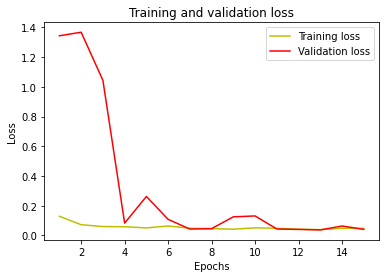

In [9]:
##################################################################
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


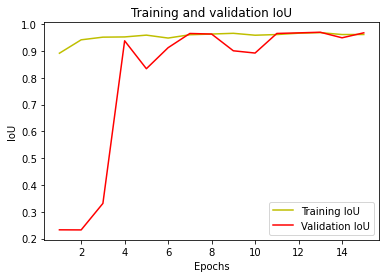

In [10]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [12]:
model.save('sea-land_20_epochs_RESNET_backbone_batch16.hdf5')

1/1 [==============================] - 2s 2s/step
Mean IoU = 0.93063617


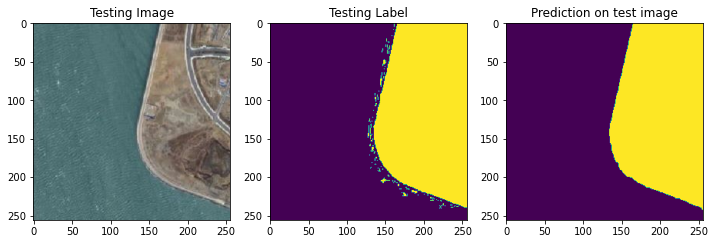

In [22]:




#####################################################

from keras.models import load_model

model = load_model("sea-land_20_epochs_RESNET_backbone_batch16.hdf5", compile=False)

#batch_size=32 #Check IoU for a batch of images

#Test generator using validation data.

test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#######################################################
#View a few images, masks and corresponding predictions. 
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()